In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

In [4]:
df = pd.read_csv("data/train.csv", sep=";")

In [5]:
df.columns.to_series().groupby(df.dtypes).groups

{int64: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], object: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']}

In [6]:
df_features = df.iloc[:,:-1]
df_target = df.iloc[:,-1]

In [7]:
# dropping the fields related to last campaign. We're just keeping the outcome from the previous campaign
df_features.drop(columns=['contact', 'day', 'month', 'duration','previous'], inplace=True)

In [8]:
df_target.replace({'yes': 1, 'no':0}, inplace=True)

In [9]:
df_features

,age,job,marital,education,default,balance,housing,loan,campaign,pdays,poutcome
0,58,management,married,tertiary,no,2143,yes,no,1,-1,unknown
1,44,technician,single,secondary,no,29,yes,no,1,-1,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,-1,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,1,-1,unknown
4,33,unknown,single,unknown,no,1,no,no,1,-1,unknown
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,3,-1,unknown
45207,71,retired,divorced,primary,no,1729,no,no,2,-1,unknown
45208,72,retired,married,secondary,no,5715,no,no,5,184,success
45209,57,blue-collar,married,secondary,no,668,no,no,4,-1,unknown


In [10]:
def label_encoding(df):
    replace_dict = {
        'job': {
            'management': 0, 'technician': 1, 'entrepreneur': 2,
            'blue-collar': 3, 'unknown': 4, 'retired': 5, 'admin.': 6,
            'services': 7, 'self-employed': 8, 'unemployed': 9,
            'housemaid': 10, 'student': 11
        },
        'marital': {'married': 0, 'single': 1, 'divorced': 2},
        'education': {'tertiary': 0, 'secondary': 1, 'unknown': 2, 'primary': 3},
        'default': {'no': 0, 'yes': 1},
        'housing': {'yes': 1, 'no': 0},
        'loan': {'no': 0, 'yes': 1},
        'poutcome': {'unknown': 0, 'failure': 1, 'other': 2, 'success': 3}
    }
    df.replace(replace_dict, inplace=True)
    return df

In [11]:
df_features = label_encoding(df_features)
clf = RandomForestClassifier(max_depth=5)
clf.fit(df_features, df_target)

RandomForestClassifier(max_depth=5)

In [12]:
probs = clf.predict_proba(df_features)
pred = clf.predict(df_features)

In [19]:
print("Probabilies of a sample being classified as positive: ", probs[:,1])
print("Prediction of samples taking 0.5 as threshold", pred)

Probabilies of a sample being classified as positive:  [0.08261962 0.07666284 0.06013035 ... 0.57586383 0.09819494 0.2169992 ]
Prediction of samples taking 0.5 as threshold [0 0 0 ... 1 0 0]


In [14]:
print(confusion_matrix(df_target, pred))
print(classification_report(df_target, pred))

[[39599   323]
 [ 4463   826]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     39922
           1       0.72      0.16      0.26      5289

    accuracy                           0.89     45211
   macro avg       0.81      0.57      0.60     45211
weighted avg       0.88      0.89      0.86     45211



Here, we see that the Precision is 0.72 which means out of all "Predicted Positives", 72% are True Positives. The recall is is just 0.16 which means out of "all positives in the data", our model was able to identify only 16% of it which is not very good.

One reason behind it can be the wrong "Threshold" because the classification report above is made by using threshold of 0.5 which means all probabilities above 0.5 will be classified as positives and the rest will be classified as negatives.

The other reason can be imbalance in the data because positive samples are just 11.4% in the overall data.

Let's look at the threshold-invariant metrics first before moving to the selection of correct threshold

In [59]:
def build_roc_curve(aucScore, fpr,tpr):
    fig = plt.figure(figsize = (15,5))
    ax = fig.add_subplot(111)
    ax.plot(fpr, tpr, label='AUC = %0.3f'% aucScore)
    ax.plot([0,1],[0,1])
    ax.set_title('Receiver operating characteristic curve (ROC)')
    ax.legend()
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    plt.show()

# Define a precision_recall_curve function
def plot_pr_curve(recall, precision, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

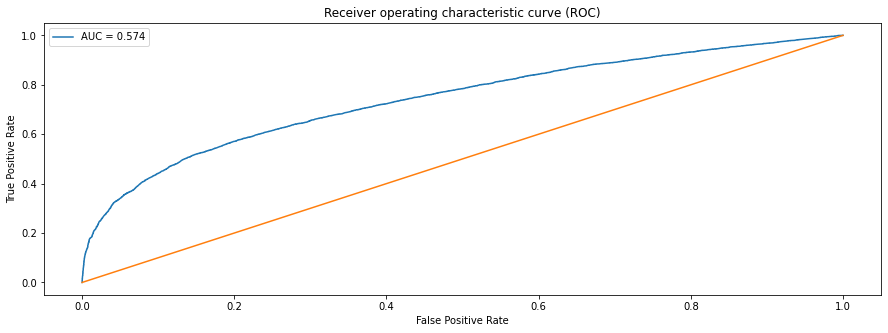

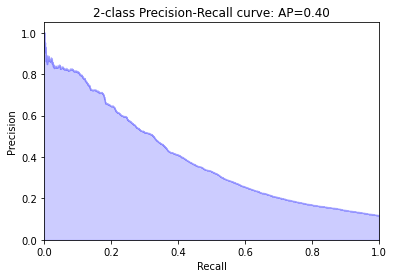

In [63]:
roc_score = roc_auc_score(np.array(df_target), pred)
fpr, tpr, thresholds = roc_curve(df_target, probs[:,1])
build_roc_curve(roc_score, fpr, tpr)

precision, recall, thresholds = precision_recall_curve(df_target, probs[:,1])
average_precision = average_precision_score(df_target, probs[:,1])
plot_pr_curve(recall, precision, average_precision)

The area under ROC curve is 0.57 wich is not good. Let's try to fix that through oversampling techniques to balance out the data.

But first, let's look at selecting the right threshold

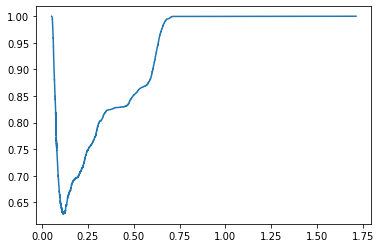

In [52]:
# here we will calculate the total Error Rate by summing up FPR and FNR
cut_off_df = pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresholds})
cut_off_df['fnr'] = 1- cut_off_df['tpr'] 

# we can also add multipliers to adjust the weights we want to give to false positives and false negatives
# For instance, we want to control False Negatives more than False Postives. In that case, we can double
# the weight of False Negatives by cut_off_df['200_fnr'] = 2*cut_off_df['fnr']
cut_off_df['100_fpr'] = cut_off_df['fpr']
cut_off_df['100_fnr'] = cut_off_df['fnr']

# Let's sum up FPR and FNR to get the total Error Rate
cut_off_df['TotalErrorRate'] = cut_off_df['100_fpr'] + cut_off_df['100_fnr']

# Let's plot the Error Rate against Threshold
plt.plot(cut_off_df['threshold'], cut_off_df['TotalErrorRate'])
plt.show()

From, the graph we can see that the minimum Error Rate is at 0.12 threshold approx.

In [57]:
pred_custom_thresh = np.int64(probs[:,1]>0.12)

In [58]:

print(confusion_matrix(df_target, pred_custom_thresh))
print(classification_report(df_target, pred_custom_thresh))

[[32752  7170]
 [ 2388  2901]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     39922
           1       0.29      0.55      0.38      5289

    accuracy                           0.79     45211
   macro avg       0.61      0.68      0.63     45211
weighted avg       0.86      0.79      0.81     45211



Now, after the selection of 0.12 as threshold, the precision has reduced to 0.29 but the good thing is that recall has increased to 0.55 from 0.16. This is a good thing because now we are able to identify 55% of positives which are available in the data. But out of all predicted positives, only 29% are True Positives.
We can play around Thresholds to find the right fit of Precision and Recall Levels.

#### Now, let's get down to fixing the imbalance in the data

### Resampling to get rid of imbalanced data
We can either do undersampling of data or oversampling of data. What happens in both of them is described below

1. UnderSampling: we take ramdom draws from majority class to match the number of minority class observations. But we randomly loose alot of information in this
2. OverSampling: Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models

Apart from these two, we have another method, which is proved more effective as compared to other two mentioned.

(SMOTE) Synthetic Minority Oversampling Technique: It overcomes the data imbalance by oversampling the minority class using nearest neighbors to create new synthetic minority class cases instead of duplicating the monority samples

In [65]:
from imblearn.over_sampling import SMOTE

In [66]:
smt = SMOTE(random_state=0)
x_sm, y_sm = smt.fit_resample(df_features, df_target)

In [69]:
clf = RandomForestClassifier(max_depth=5)
clf.fit(x_sm, y_sm)

RandomForestClassifier(max_depth=5)

In [72]:
probs = clf.predict_proba(x_sm)
pred = clf.predict(x_sm)

In [73]:
print(confusion_matrix(y_sm, pred))
print(classification_report(y_sm, pred))

[[28922 11000]
 [ 8251 31671]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     39922
           1       0.74      0.79      0.77     39922

    accuracy                           0.76     79844
   macro avg       0.76      0.76      0.76     79844
weighted avg       0.76      0.76      0.76     79844



Clearly, there is improvement in precision as well as recall

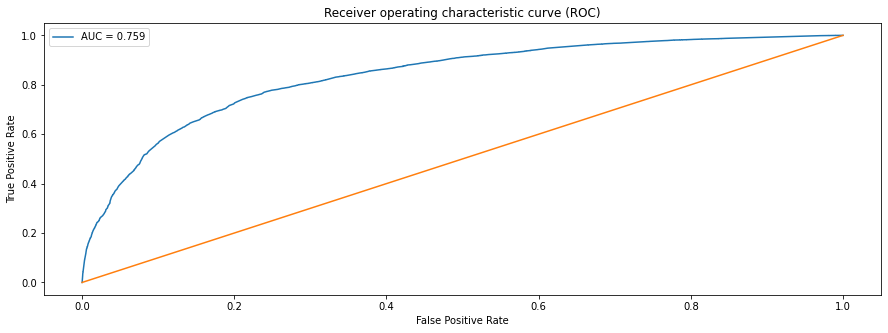

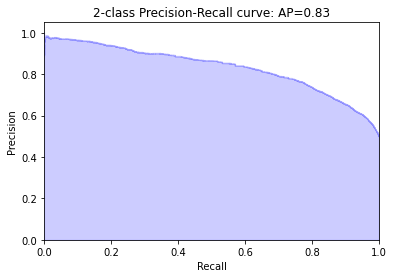

In [74]:
roc_score = roc_auc_score(np.array(y_sm), pred)
fpr, tpr, thresholds = roc_curve(y_sm, probs[:,1])
build_roc_curve(roc_score, fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_sm, probs[:,1])
average_precision = average_precision_score(y_sm, probs[:,1])
plot_pr_curve(recall, precision, average_precision)